In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from datetime import datetime
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

In [195]:
soxx_data = yf.download("SOXX", start='2021-01-01')
nvda_data = yf.download("NVDA", start='2021-01-01')
tsmc_data = yf.download("TSM", start='2021-01-01')
intc_data = yf.download("INTC", start='2021-01-01')
nxpi_data = yf.download("NXPI", start='2021-01-01')
avgo_data = yf.download("AVGO", start='2021-01-01')
txn_data = yf.download("TXN", start='2021-01-01')
amd_data = yf.download("AMD", start='2021-01-01')
data_list = [soxx_data, nvda_data, tsmc_data, intc_data, nxpi_data, avgo_data, txn_data, amd_data]
data_list_names = ["soxx_data", "nvda_data", "tsmc_data", "intc_data", "nxpi_data", "avgo_data", "txn_data", "amd_data"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [153]:
soxx_data["Close"].corr(nvda_data["Close"])

0.9488188446068953

In [154]:
soxx_data["Close"].corr(tsmc_data["Close"])

-0.003757109863184324

In [155]:
soxx_data["Close"].corr(intc_data["Close"])

-0.5278427450864056

In [156]:
soxx_data["Close"].corr(nxpi_data["Close"])

0.8022136853111411

In [157]:
soxx_data["Close"].corr(avgo_data["Close"])

0.9453770724621768

In [212]:
pval = 1
single_pval = 1
coint_val = 1
combo = 2
for i1, ticker1 in enumerate(data_list):
    single_stats = adfuller(ticker1["Close"])
    if single_stats[1] < single_pval:
        single_pval = single_stats[1]
        single_min_ticker = data_list_names[i1]
        single_min = single_stats
    for i2, ticker2 in enumerate(data_list[i1+1:]):
        coint_res = coint(ticker1["Close"], ticker2["Close"])
        if coint_res[1] < coint_val:
            coint_val = coint_res[1]
            coint_pair = data_list_names[i1] + " " + data_list_names[i1+i2+1]
        model = sm.OLS(ticker1["Close"], ticker2["Close"]).fit()
        test_res = adfuller(model.resid)
        if test_res[1] < pval:
            pval = test_res[1]
            pair_tickers = data_list_names[i1] + " " + data_list_names[i1+i2+1]
            pair = test_res
        if test_res[1] + coint_res[1] < combo:
            combo = test_res[1] + coint_res[1]
            combo_tickers = data_list_names[i1] + " " + data_list_names[i1+i2+1]
        
print(single_min_ticker)
print(single_min)
print(" ")
print(pair_tickers)
print(pair)
print(" ")
print(coint_pair)
print(coint_val)   
print(" ")
print(combo_tickers)
print(combo)
    

txn_data
(-2.985146098796241, 0.03630504539965115, 1, 229, {'1%': -3.4592326027153493, '5%': -2.8742454699025872, '10%': -2.5735414688888465}, 1090.7400906538635)
 
nxpi_data txn_data
(-2.738571606609665, 0.06759819572370056, 5, 225, {'1%': -3.4597521044060353, '5%': -2.874472927517147, '10%': -2.5736628197530864}, 1069.3197966495354)
 
avgo_data amd_data
0.0011199906533953213
 
nxpi_data txn_data
0.2688394803698743


In [255]:
ratio = txn_data["Close"] / nxpi_data["Close"]
z_score = (ratio - ratio.mean()) / np.std(ratio)
std_up = np.mean(ratio) + np.std(z_score)
std_down = np.mean(ratio) - np.std(z_score)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
z score
0.15807138269868987
z score
1.0290634416354025
1
x + self.qty1 is 28
y + self.qty2 is 28
2021-02-02T00:00:00, SELL CREATE TXN, price = 177.21, qty = 28
2021-02-02T00:00:00, BUY CREATE NXPI, price = 174.75, qty = 28
2021-02-03T00:00:00, SELL COMPLETE, 179.99
2021-02-03T00:00:00, BUY COMPLETE, 174.78
z score
1.7321774669891814
z score
2.2617343325190653
z score
2.365710154434786
z score
1.996873023090199
z score
1.7435254184421
z score
1.2244003408641206
z score
0.9812034539840271
z score
0.6417118785276433
z score
0.3824808410491705
z score
-0.18283534144965272
z score
-0.45891194568964894
z score
0.0031814472890078684
z score
-0.04666523987565238
z score
-0.5959647863391923
z score
-0.767935626990148
z score
-0.48737205141409756
z score
-0.0685713078557741
z score
-0.2042054018521384
z score
-0.686531869345476
z score
-1.2037385953985296
2
x 

<IPython.core.display.Javascript object>


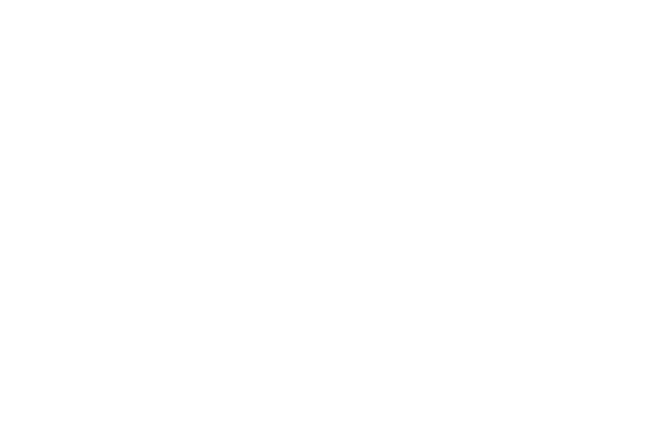

[[<Figure size 432x288 with 7 Axes>]]

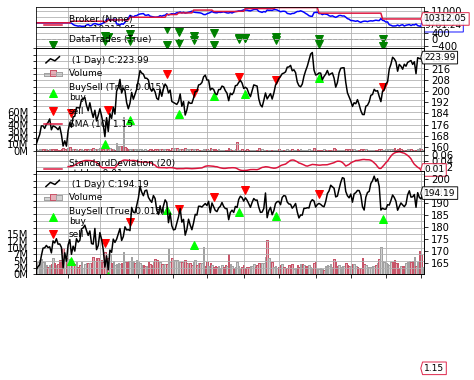

In [269]:
class TXN_NXPI(bt.Strategy):
    
    params = dict(
        period=10,
        stake=10,
        qty1=0,
        qty2=0,
        printout=True,
        status=0,
        portfolio_value=10000,
    )

    def log(self, txt, dt=None):
        if self.params.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = False

    def __init__(self):
        # To control operation entries
        self.orderid = False
        self.qty1 = self.params.qty1
        self.qty2 = self.params.qty2
        self.status = self.params.status
        self.portfolio_value = self.params.portfolio_value

        ratio = self.data0.close / self.data1.close
        mean = bt.ind.SMA(ratio, period=20)
        self.z_score = (ratio - mean) / bt.ind.StandardDeviation(ratio)
        

    def next(self):
        print("z score")
        print(self.z_score[0])
        if self.orderid != False:
            return  # if an order is active, no new orders are allowed

        if (self.z_score[0] > 1) and (self.status != 1):
            print("1")

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close[0]))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close[0]))  # Find the number of shares for Stock2
            print('x + self.qty1 is', x + self.qty1)
            print('y + self.qty2 is', y + self.qty2)

            # Placing the order
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % ("TXN", self.data0.close[0], x + self.qty1))
            self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % ("NXPI", self.data1.close[0], y + self.qty2))
            self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            self.status = 1  # The current status is "short the spread"

            # Step 3: Check conditions for LONG & place the order
            # Checking the condition for LONG
        elif (self.z_score[0] < -1) and (self.status != 2):
            print("2")

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close[0]))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close[0]))  # Find the number of shares for Stock2
            print('x + self.qty1 is', x + self.qty1)
            print('y + self.qty2 is', y + self.qty2)

            # Place the order
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % ("PEP", self.data0.close[0], x + self.qty1))
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % ("KO", self.data1.close[0], y + self.qty2))
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares
            self.status = 2  # The current status is "long the spread"


            # Step 4: Check conditions for No Trade
            # If the z-score is within the two bounds, close all
        
#         elif (self.z_score[0] < 1 and self.z_score[0] > -1):
#             self.log('CLOSE LONG %s, price = %.2f' % ("NXPI", self.data0.close[0]))
#             self.close(self.data0)
#             self.log('CLOSE LONG %s, price = %.2f' % ("TXN", self.data1.close[0]))
#             self.close(self.data1)
        

            
    def stop(self):
        print('==================================================')
        print('Starting Value - %.2f' % self.broker.startingcash)
        print('Ending   Value - %.2f' % self.broker.getvalue())
        print('==================================================')



cerebro = bt.Cerebro()
cerebro.addstrategy(TXN_NXPI)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.002)

NXPI = yf.download("NXPI", start='2021-01-01')
data0 = bt.feeds.PandasData(dataname=NXPI)
cerebro.adddata(data0)

TXN = yf.download("TXN", start='2021-01-01')
data1 = bt.feeds.PandasData(dataname=TXN)
cerebro.adddata(data1)

cerebro.run()
cerebro.plot()